# Denver Crime Analysis
### CSPB 3022 Final Project Notebook
### Justin Teufel

# Introduction
The following notebook details and Exploratory Data Analysis and __Regression Analysis__ on the city of Denver’s crime dataset, census dataset, and Zillow’s property sales dataset. The goal of the analysis is to find correlations between the crime rates in Denver neighborhoods and other demographic + housing statistics/trends, and if these correlations exist - attempt to develop a multivariate regression model of the relationships. 

There are two parts to the study, the first part involves analyzing the demographic conditions (income, percentage of minorities, education levels) of various neighborhoods in Denver against the crime rates of those neighborhoods. The second part introduces Zillow’s housing data for each neighborhood in an attempt to improve on the first study.


In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import io
import requests
import json
from categories import month_years,demographics,income_levels,age_distribution,education_levels,houseing_levels

### Functions to be used later in the analysis:

In [2]:
def Get_Online_Data(columns,row_count,file_url):

    #return dataframe with data csv url
    #https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url

    r = requests.get(file_url).content #get content from http request
    decoded_file = io.StringIO(r.decode('utf-8'))
    df = pd.read_csv(decoded_file,nrows = row_count, usecols = columns) # add new csv lines(crimes) to dataframe
    df.FIRST_OCCURRENCE_DATE, df.LAST_OCCURRENCE_DATE = pd.to_datetime(df.FIRST_OCCURRENCE_DATE),pd.to_datetime(df.LAST_OCCURRENCE_DATE)

    return df

def Add_Crime_Columns(census_df,crime_df,crime_string):

        neighborhood_totals = crime_df[crime_df.OFFENSE_CATEGORY_ID == crime_string].groupby("NEIGHBORHOOD_ID")['OFFENSE_ID'].count()
        neighborhood_totals = neighborhood_totals.reset_index()
        neighborhood_totals.rename(columns = {'OFFENSE_ID':crime_string}, inplace = True)

        return census_df.merge(neighborhood_totals, on = 'NEIGHBORHOOD_ID')

def Add_AllCrimes_Columns(census_df,crime_df):

        neighborhood_totals = crime_df.groupby("NEIGHBORHOOD_ID")['OFFENSE_ID'].count()
        neighborhood_totals = neighborhood_totals.reset_index()
        neighborhood_totals.rename(columns = {'OFFENSE_ID':'all_crimes'}, inplace = True)

        return census_df.merge(neighborhood_totals, on = 'NEIGHBORHOOD_ID')

def Add_Crime_Columns_ByYear(census_df,crime_df,crime_string,neighborhoods_difference,years_difference):

        neighborhood_totals = crime_df[crime_df.OFFENSE_CATEGORY_ID == crime_string]
        neighborhood_totals = neighborhood_totals.groupby(["NEIGHBORHOOD_ID","year"])['OFFENSE_ID'].count()
        neighborhood_totals = neighborhood_totals.reset_index()
        neighborhood_totals.rename(columns = {'OFFENSE_ID':crime_string}, inplace = True)

        for n in neighborhoods_difference:
            idx = neighborhood_totals[neighborhood_totals.NEIGHBORHOOD_ID == n].index
            #print(idx)
            neighborhood_totals = neighborhood_totals.drop(idx)

        for y in years_difference:
            idx = neighborhood_totals[neighborhood_totals.year == y].index
            #print(idx)
            neighborhood_totals = neighborhood_totals.drop(idx)

        return census_df.merge(neighborhood_totals, on = ['NEIGHBORHOOD_ID','year'])


def Add_CensusData_ByYear(census_df,neighborhoods_difference):

        for n in neighborhoods_difference:
            idx = census_df[census_df.NEIGHBORHOOD_ID == n].index
            census_df = census_df.drop(idx)

        return census_df#.append([census_df]*2,ignore_index=True)


def Add_Crime_Rates(census_df,crime):

        str = crime +"_rate"
        census_df[str] = census_df[crime]/census_df['TTL_POPULATION_ALL']
        return census_df

## Data

The first part of the study involves the use of Denver’s crime dataset, and census dataset. The crime dataset is a list of all recorded crimes in Denver dating back to 2016 - information on the type of crime, location (address and neighborhood), and date are included in the dataset. The census dataset includes demographic statistics for each neighborhood, such as income levels, racial percentages, education levels, etc. Both datasets are in CSV format. We will introduce zillow’s sales dataset in the second part of the study. 

The crime dataset is too be to be uploa

In [3]:
"""
#Use this code if you don't want to download the crime csv

file_url = "https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv"    
crime_df = Get_Online_Data(columns,400000,file_url)
"""

#paths to all the csv's
crime_file = "crime.csv"
census_file = "american_community_survey_nbrhd_2014_2018.csv"
zillow_saleprices_file = "Sale_Prices_Neighborhood.csv"

## Data Cleaning

Before the analysis could be done, desired data from both csv’s needed to be combined in a single data frame of census & crime statistics for each neighborhood (each row corresponding to a neighborhood). The cleaning/ formatting steps were as follows:
   - Create a pandas data frame for each csv.
   - Assure neighborhood strings were identically formatted (all lowercase).
   - Extract neighborhood statistics from crime data frame, add columns of those statistics to the census data frame. 
   - Add columns for crime __rates__ for each desired crime. (crimes per capita)
   - Check for NaN values. 


In [4]:
#this may take 5-10min

#columns to use from crime csv
crime_columns = ["OFFENSE_ID","OFFENSE_TYPE_ID","OFFENSE_CATEGORY_ID","FIRST_OCCURRENCE_DATE","LAST_OCCURRENCE_DATE","NEIGHBORHOOD_ID","INCIDENT_ADDRESS"]

#columns for the cencus dataframe and zillow housing prices dataframe
census_columns = ["NBHD_NAME","TTL_POPULATION_ALL"] + demographics + income_levels + houseing_levels + age_distribution + education_levels
zillow_columns = ["RegionName","StateName"] + month_years

#create dataframe from the crime data
crime_df = pd.read_csv(crime_file, usecols = crime_columns)
crime_df['NEIGHBORHOOD_ID'] = crime_df['NEIGHBORHOOD_ID'].str.replace('-',' ')
crime_df['year'] = pd.DatetimeIndex(crime_df["FIRST_OCCURRENCE_DATE"]).year


#create dataframe from the census data and list of all unique neighborhoods
census_df = pd.read_csv(census_file, usecols = census_columns)
census_df.rename(columns = {"NBHD_NAME":"NEIGHBORHOOD_ID"}, inplace = True)
census_df["NEIGHBORHOOD_ID"] = census_df["NEIGHBORHOOD_ID"].str.lower()

#add new statistics for minority percentage & percentage of those with a college degree
census_df["PCT_MINORITY"] = census_df["PCT_HISPANIC"] + census_df["PCT_BLACK"]
census_df['COLLEGE_RATE'] = census_df['BACHELORS_OR_HIGHER_EDU']/census_df['TTL_POPULATION_ALL']

#list of crimes to analyze
crimes = ["theft-from-motor-vehicle","drug-alcohol","burglary","auto-theft","public-disorder","sexual-assault"]

#add crime counts & rates to the dataframe
for crime in crimes:
    census_df = Add_Crime_Columns(census_df,crime_df,crime)
    census_df = Add_Crime_Rates(census_df,crime)

census_df = Add_AllCrimes_Columns(census_df,crime_df)
census_df['ttl_crime_rate'] = census_df['all_crimes']/census_df['TTL_POPULATION_ALL']

census_df.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


,NEIGHBORHOOD_ID,TTL_POPULATION_ALL,PCT_HISPANIC,PCT_WHITE,PCT_BLACK,PCT_NATIVEAM,PCT_ASIAN,PCT_HAWAIIANPI,PCT_OTHERRACE,PCT_TWOORMORE_RACES,...,burglary,burglary_rate,auto-theft,auto-theft_rate,public-disorder,public-disorder_rate,sexual-assault,sexual-assault_rate,all_crimes,ttl_crime_rate
0,bear valley,9247.0,32.579233,55.565592,5.248248,1.677352,4.437449,0.000000,0.000000,0.492126,...,187,0.020223,386,0.041743,471,0.050935,29,0.003136,3182,0.344112
1,harvey park south,9410.0,49.512896,36.317281,2.727732,0.157335,6.330533,4.840104,0.000000,0.114120,...,179,0.019022,345,0.036663,455,0.048353,44,0.004676,3716,0.394899
2,southmoor park,5505.0,5.814006,83.199667,3.978772,0.152517,4.896716,0.000000,0.000000,1.958323,...,186,0.033787,148,0.026885,224,0.040690,13,0.002361,2358,0.428338
3,hampden south,16259.0,11.562028,72.854423,8.051068,0.045669,5.431625,0.000000,0.276339,1.778849,...,402,0.024725,440,0.027062,640,0.039363,54,0.003321,8447,0.519528
4,goldsmith,6045.0,20.843672,63.821340,9.313482,0.744417,2.150538,0.000000,0.066170,3.060380,...,184,0.030438,301,0.049793,387,0.064020,34,0.005624,4002,0.662035


### Check for columns with NaN values

__If none found, dont drop anything__

In [6]:
NaN = len(census_df) - census_df.count()
NaN

NEIGHBORHOOD_ID                  0
TTL_POPULATION_ALL               0
PCT_HISPANIC                     0
PCT_WHITE                        0
PCT_BLACK                        0
PCT_NATIVEAM                     0
PCT_ASIAN                        0
PCT_HAWAIIANPI                   0
PCT_OTHERRACE                    0
PCT_TWOORMORE_RACES              0
AGE_LESS_5                       0
AGE_5_TO_9                       0
AGE_10_TO_14                     0
AGE_15_TO_17                     0
AGE_0_TO_9                       0
AGE_10_TO_19                     0
AGE_20_TO_29                     0
AGE_30_TO_39                     0
AGE_40_TO_49                     0
AGE_50_TO_59                     0
AGE_60_TO_69                     0
AGE_70_TO_79                     0
AGE_80_PLUS                      0
LESS_THAN_HS_DIPLOMA_EDU         0
HSGRAD_OR_EQUIV_EDU              0
SOMECOLLEGE_OR_AA_EDU            0
BACHELORS_OR_HIGHER_EDU          0
PER_CAPITA_INCOME                0
AVG_HH_INCOME       

## Exploratory Data Analysis
Now that the data is properly formated we can perform some initial analysis to search for correlations. My approach was to use the more general census statistics and plot those against several different crime rates.  

I used the following census statistics: __Average Household Income, Percentage of Minorities, College Education Rate__.  I weighed these against the following crime rates: __Burglary, Auto Theft, All Crimes__

In [10]:
ttl_pp = census_df[["ttl_crime_rate",'AVG_HH_INCOME',"COLLEGE_RATE","PCT_MINORITY"]]
autotheft_pp = census_df[["auto-theft_rate",'AVG_HH_INCOME',"COLLEGE_RATE","PCT_MINORITY"]]
burglary_pp = census_df[["burglary_rate",'AVG_HH_INCOME',"COLLEGE_RATE","PCT_MINORITY"]]

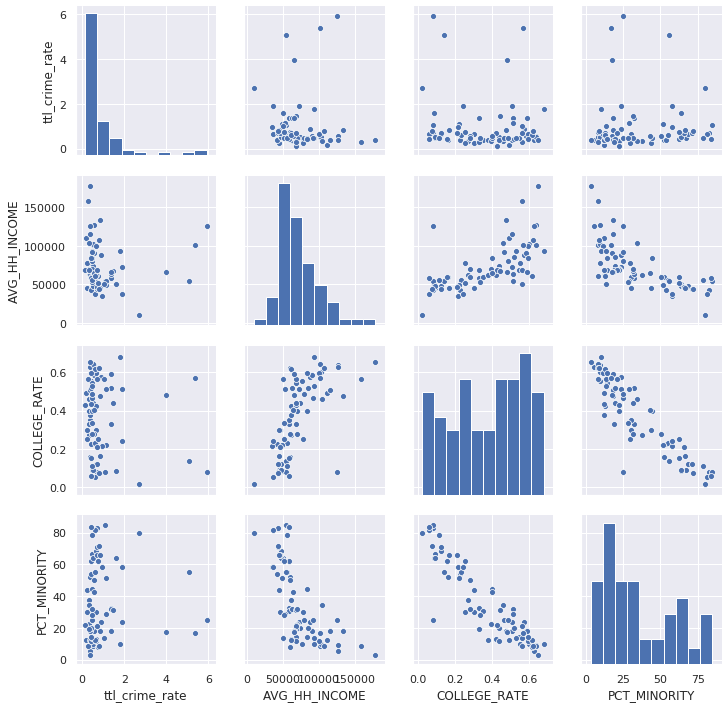

In [7]:
sns.pairplot(ttl_pp)

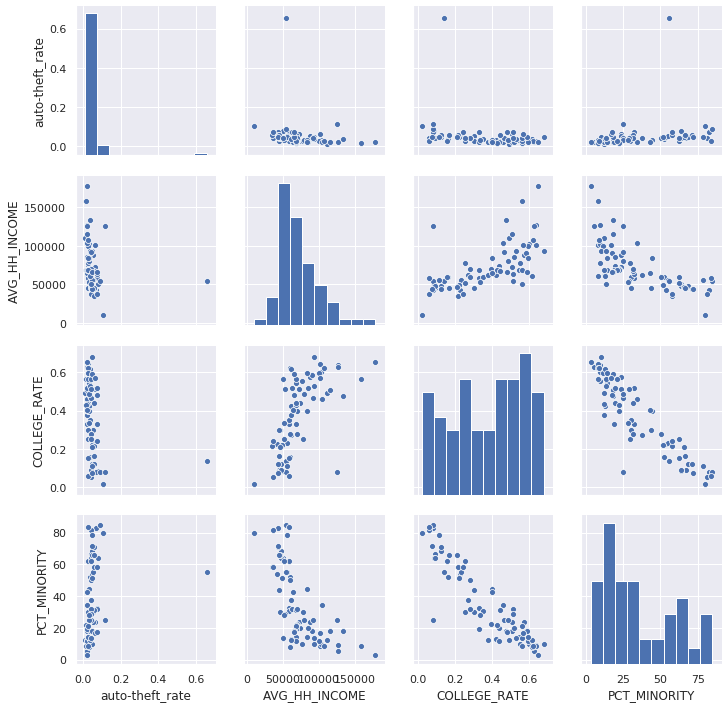

In [8]:
sns.pairplot(autotheft_pp)

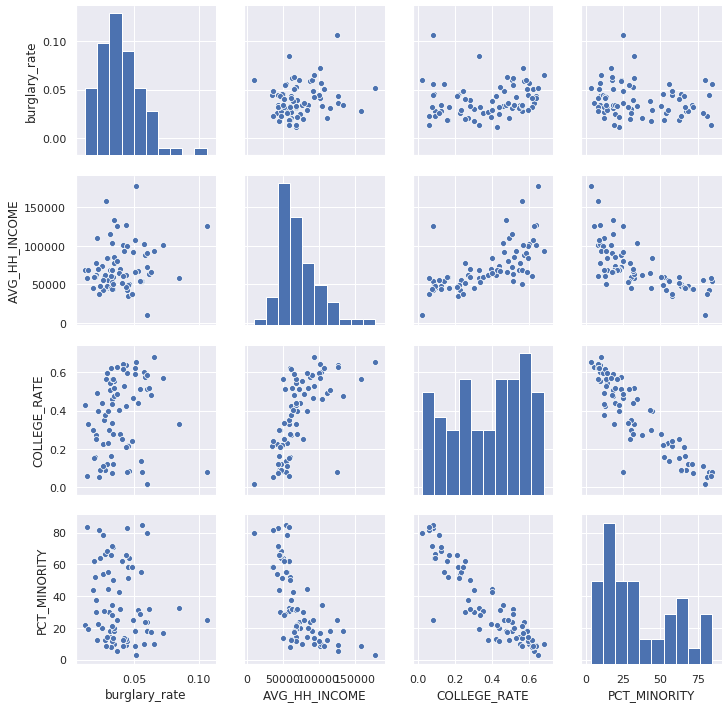

In [9]:
sns.pairplot(burglary_pp)

## Results:
I observed several strong correlations between census statistics (not unexpected), but very few between crime rates and census statistics. The only possible correlation that I observed was between the __Burglary Rate and the Average Household Income.__ I then checked the burglary rate against similar statistics (Per Capita Income, Median Earnings).

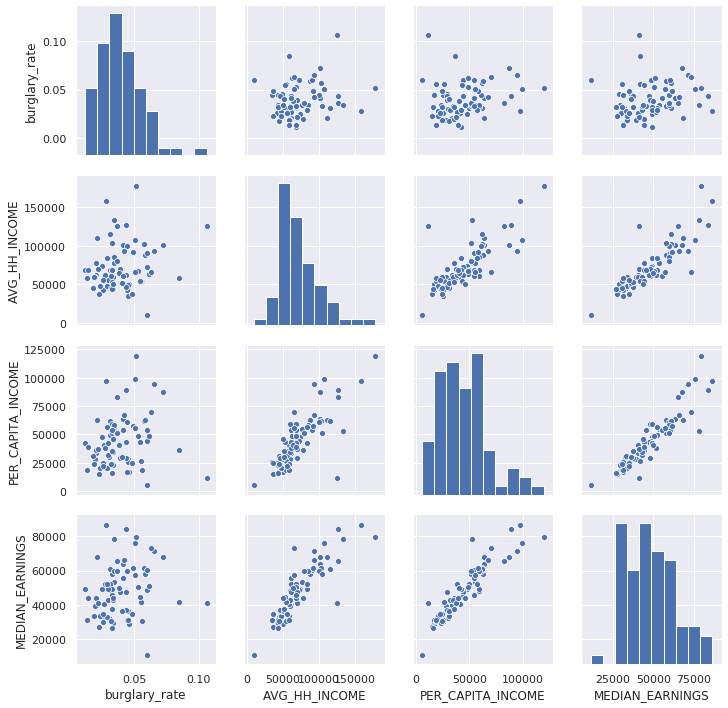

In [12]:
burglary_pp2 = census_df[["burglary_rate",'AVG_HH_INCOME','PER_CAPITA_INCOME','MEDIAN_EARNINGS']]
sns.pairplot(burglary_pp2)

# First Modeling Attempt
## Attempt 1a:
Since I observed similar possible correlations between the additional two statistics, I attempted to fit a linear regression model between the burglary rate (dependant variable) and the three income-related statistics with all possible interactions. 


In [13]:
#first model
model_burglary = smf.ols(formula='burglary_rate ~ PER_CAPITA_INCOME*AVG_HH_INCOME*MEDIAN_EARNINGS', data=census_df).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.900
Date:                Sun, 03 May 2020   Prob (F-statistic):             0.0934
Time:                        18:10:33   Log-Likelihood:                 206.51
No. Observations:                  75   AIC:                            -399.0
Df Residuals:                      68   BIC:                            -382.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        1.519e-11   8.15e-12      1.864      0.067   -1.07e-12    3.14e-11
PER_CAPITA_INCOME                               -9.145e-07   1.05e-06     -0.869      0.388   -3.01e-06    1.19e-06
AVG_HH_INCOME                                     1.34e-06   3.42e-07      3.916      0.000    6.57e-07    2.02e-06
PER_CAPITA_INCOME:AVG_HH_INCOME                 -9.541e-12   1.13e-11     -0.844      0.402   -3.21e-11     1.3e-11
MEDIAN_EARNINGS                                   4.26e-07   6.65e-07      0.640      0.524   -9.02e-07    1.75e-06
PER_CAPITA_INCOME:MEDIAN_EARNINGS                2.364e-11   1.12e-11      2.102      0.039     1.2e-12    4.61e-11
AVG_HH_INCOME:MEDIAN_EARNINGS                   -2.054e-11    6.5e-12     -3.157      0.002   -3.35e-11   -7.56e-12
PER_CAPITA_INCOME:AVG_HH_INCOME:MEDIAN_EARNINGS  8.415e-17   1.02e-16      0.829      0.410   -1.18e-16    2.87e-16
==============================================================================
Omnibus:                       10.985   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.334
Skew:                           0.798   Prob(JB):                      0.00346
Kurtosis:                       4.040   Cond. No.                     4.35e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Results

The resulting model was not only a poor fit as indicated by the low R-squared value but most of the variables and interactions had high p-values, indicating that they were not statistically significant. 

## Attempt 1b:

For the next attempt, I used the variables from the previous model that had the lowest p-values and attempted to fit a new model using those variables & interactions. The resulting model had a poor fit, but I attempted to improve it by checking the residual plot for any outliers that could have been affecting the model.

In [14]:
#second model
model_burglary = smf.ols(formula='burglary_rate ~ AVG_HH_INCOME*MEDIAN_EARNINGS', data=census_df).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.118
Date:                Sun, 03 May 2020   Prob (F-statistic):              0.348
Time:                        18:11:41   Log-Likelihood:                 202.43
No. Observations:                  75   AIC:                            -396.9
Df Residuals:                      71   BIC:                            -387.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0212      0.014      1.507      0.136      -0.007       0.049
AVG_HH_INCOME                  1.861e-07   2.58e-07      0.721      0.473   -3.28e-07       7e-07
MEDIAN_EARNINGS                2.642e-07   3.24e-07      0.816      0.417   -3.82e-07     9.1e-07
AVG_HH_INCOME:MEDIAN_EARNINGS -2.159e-12   3.43e-12     -0.630      0.531   -8.99e-12    4.67e-12
==============================================================================
Omnibus:                       19.667   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.050
Skew:                           1.110   Prob(JB):                     1.34e-06
Kurtosis:                       4.931   Cond. No.                     3.44e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Find outliers in the leverage plot:

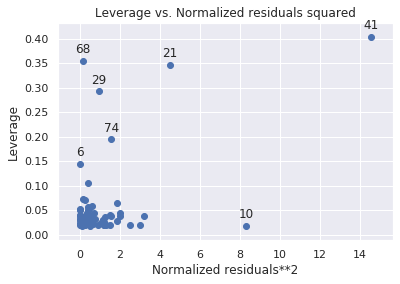

In [15]:
sm.graphics.plot_leverage_resid2(model_burglary, alpha=0.05);
plt.show()

## Attempt 1c:

For the next attempt, we drop 5 outliers, and observe a slightly improved (but still poor) fit, and improved p-statistics. 

In [19]:
census_df_d = census_df.drop([41,10,21,24,73,53])

#third model
model_burglary = smf.ols(formula='burglary_rate ~ AVG_HH_INCOME*MEDIAN_EARNINGS', data=census_df_d).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.392
Date:                Sun, 03 May 2020   Prob (F-statistic):           8.54e-05
Time:                        18:16:27   Log-Likelihood:                 214.34
No. Observations:                  69   AIC:                            -420.7
Df Residuals:                      65   BIC:                            -411.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0235      0.013      1.867      0.066      -0.002       0.049
AVG_HH_INCOME                 -4.876e-07    2.5e-07     -1.954      0.055   -9.86e-07    1.07e-08
MEDIAN_EARNINGS                8.462e-07   2.48e-07      3.414      0.001    3.51e-07    1.34e-06
AVG_HH_INCOME:MEDIAN_EARNINGS  1.859e-12   3.07e-12      0.606      0.547   -4.27e-12    7.98e-12
==============================================================================
Omnibus:                        3.784   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.278
Skew:                           0.438   Prob(JB):                        0.194
Kurtosis:                       2.389   Cond. No.                     4.47e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Find outliers in the leverage plot:

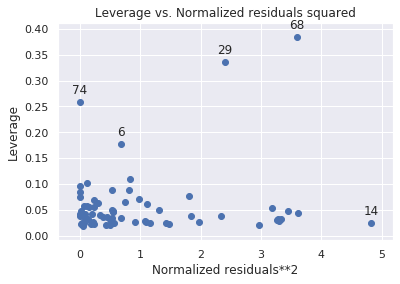

In [18]:
sm.graphics.plot_leverage_resid2(model_burglary, alpha=0.05);
plt.show()

## Attempt 1d:

We repeat the same process several times until we observe in an R-squared of at least .6 . While the fit is ok - the p-statistic for the interaction is high, and we've removed a significant amount of data (aprx. 1/3rd of all samples).

In [25]:
census_df_d = census_df.drop([41,10,21,24,73,53,14,68,29,9,19,18,27,20,35,62,43,58,26,25,22,54,57,40,47])

model_burglary = smf.ols(formula='burglary_rate ~ AVG_HH_INCOME*MEDIAN_EARNINGS', data=census_df_d).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     25.43
Date:                Sun, 03 May 2020   Prob (F-statistic):           7.55e-10
Time:                        18:21:26   Log-Likelihood:                 185.96
No. Observations:                  50   AIC:                            -363.9
Df Residuals:                      46   BIC:                            -356.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0166      0.009      1.763      0.084      -0.002       0.035
AVG_HH_INCOME                 -4.642e-07    1.7e-07     -2.739      0.009   -8.05e-07   -1.23e-07
MEDIAN_EARNINGS                9.197e-07   1.97e-07      4.677      0.000    5.24e-07    1.32e-06
AVG_HH_INCOME:MEDIAN_EARNINGS  1.383e-12   2.44e-12      0.567      0.573   -3.53e-12    6.29e-12
==============================================================================
Omnibus:                        3.206   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.316
Skew:                           0.360   Prob(JB):                        0.314
Kurtosis:                       2.230   Cond. No.                     4.66e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Attempt 1e (Final):

For the final model, we drop the interaction so both variables are statistically significant.

In [26]:
model_burglary = smf.ols(formula='burglary_rate ~ AVG_HH_INCOME+MEDIAN_EARNINGS', data=census_df_d).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     38.53
Date:                Sun, 03 May 2020   Prob (F-statistic):           1.24e-10
Time:                        18:21:49   Log-Likelihood:                 185.78
No. Observations:                  50   AIC:                            -365.6
Df Residuals:                      47   BIC:                            -359.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0115      0.003      3.795      0.000       0.005       0.018
AVG_HH_INCOME   -3.781e-07   7.48e-08     -5.055      0.000   -5.29e-07   -2.28e-07
MEDIAN_EARNINGS  1.004e-06   1.27e-07      7.883      0.000    7.48e-07    1.26e-06
==============================================================================
Omnibus:                        3.203   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                2.378
Skew:                           0.377   Prob(JB):                        0.305
Kurtosis:                       2.243   Cond. No.                     3.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Attempt 1 Conclusion:

Though there may appear to be a correlation between the two income statistics and the burglary rate, a model with an OK fit can only be achieved by dropping a large portion of samples - dropping roughly ⅓ of the samples only got us to an R-squared of .6. The variable may not be appropriate for fitting a linear regression model to determine burglary rates. 

The weak correlation could possibly be attributed to the small sample size since each sample correlates to a neighborhood, or they’re just may not be a strong relationship between the variables. 

In the next part of the study, we attempt to find a better model by both increasing the sample size and introducing a new statistic (neighborhood home values).


### AVG Household Income - Burglary Rate's Plot (with outliers dropped)

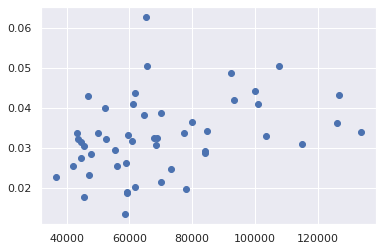

In [37]:
plt.plot(census_df_d["AVG_HH_INCOME"], census_df_d["burglary_rate"], 'bo')

### Median Earnings - Burglary Rate's Plot (with outliers dropped)

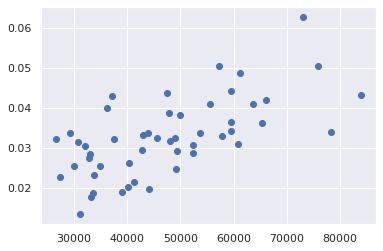

In [28]:
plt.plot(census_df_d["MEDIAN_EARNINGS"], census_df_d["burglary_rate"], 'bo')

# Second Modeling attempt:

The second part of our analysis introduces Zillow’s housing data for each neighborhood in an attempt to improve on the first study. The “Sales_Prices-Neighborhood” CSV contains average property sales values for most neighborhoods in the United States at monthly intervals dating back to 2008. 

Our approach will be to introduce this new data into our census data frame - however, we’ll need to increase the row count to account for the time intervals in the Zillow dataset. We’ll use annual intervals instead of monthly intervals, so each row of our data frame will correspond to a neighborhood year combo. We’ll only use 3 years (2017,2018, and 2019) since the crime CSV only has those years in full - as a result, our new data frame will have 3 times as many rows (therefore 3 times the samples).

## Gathering/Formatting Additional Data:

Rather than updating the data frame from part 1 - we’ll just make a new one. We’ll need to recalculate all the crime statistics so we have crime rates for each neighborhood for each year. Similar to what we did with the census dataset, we’ll need to format the Zillow neighborhood names to match the census (all lowercase). Unfortunately, the Zillow dataset does not include every neighborhood in Denver, so we’ll have to exclude those neighborhoods from this analysis.

Our census dataset, unfortunately, does not have statistics broken out by year, so we keep them constant from year to year (not ideal). 

In [6]:
#load in zillow sales data
zillow_sales_df = pd.read_csv(zillow_saleprices_file, usecols = zillow_columns)

#filter all colorado neighborhoods out of the zillow sales csv
colorado_sales_df = zillow_sales_df[zillow_sales_df.StateName == "Colorado"]
colorado_sales_df["RegionName"] = colorado_sales_df["RegionName"].str.lower()

#get neighborhood & years difference and intersection for dataframe merging
neighborhoods_zillow = set(colorado_sales_df["RegionName"])
neighborhoods = set(census_df["NEIGHBORHOOD_ID"])
years_c = set(crime_df["year"])
neighborhoods_intersection = list(neighborhoods.intersection(neighborhoods_zillow))
neighborhoods_difference = list(neighborhoods.difference(neighborhoods_zillow))
years_difference = list(years_c.difference({2017,2018,2019}))


#make new dataframe for all the denver sales data
denver_sales_df = pd.DataFrame([], columns = colorado_sales_df.columns)


for neighborhood in neighborhoods_intersection:
    denver_sales_df = denver_sales_df.append(colorado_sales_df[colorado_sales_df.RegionName == neighborhood])


#make a column for annual sales averages
#not proud of these 3 lines of code
denver_sales_df["2017"] = (denver_sales_df["2017-01"] + denver_sales_df["2017-02"] + denver_sales_df["2017-03"] + denver_sales_df["2017-04"] + denver_sales_df["2017-05"] + denver_sales_df["2017-06"] + denver_sales_df["2017-07"] + denver_sales_df["2017-08"] + denver_sales_df["2017-09"] + denver_sales_df["2017-10"] + denver_sales_df["2017-11"] + denver_sales_df["2017-12"])/12
denver_sales_df["2018"] = (denver_sales_df["2018-01"] + denver_sales_df["2018-02"] + denver_sales_df["2018-03"] + denver_sales_df["2018-04"] + denver_sales_df["2018-05"] + denver_sales_df["2018-06"] + denver_sales_df["2018-07"] + denver_sales_df["2018-08"] + denver_sales_df["2018-09"] + denver_sales_df["2018-10"] + denver_sales_df["2018-11"] + denver_sales_df["2018-12"])/12
denver_sales_df["2019"] = (denver_sales_df["2019-01"] + denver_sales_df["2019-02"] + denver_sales_df["2019-03"] + denver_sales_df["2019-04"] + denver_sales_df["2019-05"] + denver_sales_df["2019-06"] + denver_sales_df["2019-07"] + denver_sales_df["2019-08"] + denver_sales_df["2019-09"] + denver_sales_df["2019-10"] + denver_sales_df["2019-11"] + denver_sales_df["2019-12"])/12


#make new census dataframe that includes annual sales dataframe
#rather than a row for each neighborhood - there is a row for each year-neightborhood combo
#we'll use only 2017, 2018 and 2019 because those are the only complete years in the crime csv

census_df2 = pd.DataFrame([], columns = [])

idx = 0
for year in [2017,2018,2019]:
    for neighborhood in neighborhoods_intersection:
        try:
            temp = int(denver_sales_df[denver_sales_df.RegionName == neighborhood][str(year)])
        except:
            temp = denver_sales_df[denver_sales_df.RegionName == neighborhood][str(year)]

        temp_df = pd.DataFrame({"NEIGHBORHOOD_ID":neighborhood,"year":year,"MEDIAN_HOME_VALUE":temp}, index=[idx])
        census_df2 = census_df2.append(temp_df, ignore_index=True)
        idx +=1

#add crime statistics for 2017,2018,and 2019 for each neighborhood
for crime in crimes:
    census_df2 = Add_Crime_Columns_ByYear(census_df2,crime_df,crime,neighborhoods_difference,years_difference)

#add census data from original census dataframe
census_df_m = census_df[["TTL_POPULATION_ALL","PCT_MINORITY","COLLEGE_RATE",'PER_CAPITA_INCOME','AVG_HH_INCOME','AVG_FAM_INCOME','MEDIAN_EARNINGS','NEIGHBORHOOD_ID']]
census_df2 = census_df2.merge(Add_CensusData_ByYear(census_df_m,neighborhoods_difference), on = 'NEIGHBORHOOD_ID')

#need to add ttl crimes column
for crime in crimes:
    census_df2 = Add_Crime_Rates(census_df2,crime)

census_df2.head(12)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,NEIGHBORHOOD_ID,year,MEDIAN_HOME_VALUE,theft-from-motor-vehicle,drug-alcohol,burglary,auto-theft,public-disorder,sexual-assault,TTL_POPULATION_ALL,...,PER_CAPITA_INCOME,AVG_HH_INCOME,AVG_FAM_INCOME,MEDIAN_EARNINGS,theft-from-motor-vehicle_rate,drug-alcohol_rate,burglary_rate,auto-theft_rate,public-disorder_rate,sexual-assault_rate
0,university hills,2017,393708,68,30,49,45,58,4,5729.0,...,43645,61777,91702,47576,0.011869,0.005237,0.008553,0.007855,0.010124,0.000698
1,university hills,2018,439366,113,55,48,47,60,8,5729.0,...,43645,61777,91702,47576,0.019724,0.009600,0.008378,0.008204,0.010473,0.001396
2,university hills,2019,468816,65,37,38,27,50,7,5729.0,...,43645,61777,91702,47576,0.011346,0.006458,0.006633,0.004713,0.008728,0.001222
3,hampden,2017,270041,227,37,119,175,185,17,20007.0,...,41095,58986,72139,40343,0.011346,0.001849,0.005948,0.008747,0.009247,0.000850
4,hampden,2018,286583,224,58,104,146,168,15,20007.0,...,41095,58986,72139,40343,0.011196,0.002899,0.005198,0.007297,0.008397,0.000750
5,hampden,2019,317883,220,37,67,148,160,16,20007.0,...,41095,58986,72139,40343,0.010996,0.001849,0.003349,0.007397,0.007997,0.000800
6,cherry creek,2017,754150,67,18,76,33,71,1,6989.0,...,98997,107574,186538,75809,0.009586,0.002575,0.010874,0.004722,0.010159,0.000143
7,cherry creek,2018,735350,71,23,51,34,47,5,6989.0,...,98997,107574,186538,75809,0.010159,0.003291,0.007297,0.004865,0.006725,0.000715
8,cherry creek,2019,850450,107,15,68,46,54,7,6989.0,...,98997,107574,186538,75809,0.015310,0.002146,0.009730,0.006582,0.007726,0.001002
9,stapleton,2017,509741,209,131,142,169,205,25,24389.0,...,52620,133744,156065,78276,0.008569,0.005371,0.005822,0.006929,0.008405,0.001025


## Second Exploratory Data Analysis

For the second EDA, we look for correlations between average neighborhood home sale value from zillow (mistakingly labeled as median home value) and burglary rate (along with the previous census statistics).

In [77]:
census_df_filtered = census_df2[["burglary_rate",'MEDIAN_HOME_VALUE','AVG_HH_INCOME',"COLLEGE_RATE","PCT_MINORITY"]]

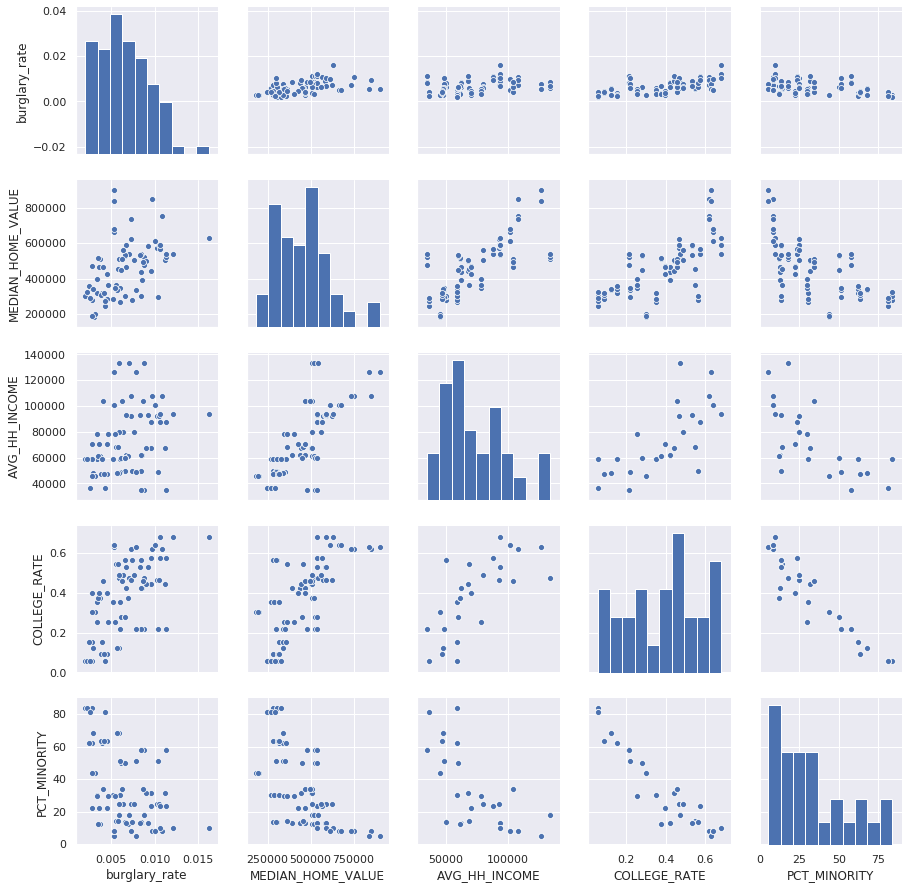

In [9]:
sns.pairplot(census_df_filtered)

### Results:

There appear to be clear correlations between home value and the burglary rate, and the college education rate and burglary rate. Other correlations also exist between census statistics and home values. 

## Additional Data Cleaning:

We’ll need to do some additional data cleaning to drop NaN values introduced from the Zillow dataset. 

In [78]:
#Number of NaN values
print(str(len(census_df_filtered) - census_df_filtered['MEDIAN_HOME_VALUE'].count()) + " NaN's in dataset")

#Dropna not working for whatever reason
#drop all indecies with NaN's
index = set(census_df_filtered['MEDIAN_HOME_VALUE'].index)
index_dif = set(census_df_filtered['MEDIAN_HOME_VALUE'].index[census_df_filtered.MEDIAN_HOME_VALUE > 0])
index = index.difference(index_dif)
census_df_filtered = census_df_filtered.drop(list(index))

print("Now " + str(len(census_df_filtered) - census_df_filtered['MEDIAN_HOME_VALUE'].count()) + " NaN's in dataset")

#convert all values to int
census_df_filtered['MEDIAN_HOME_VALUE'] = census_df_filtered['MEDIAN_HOME_VALUE'].astype(int)

6 NaN's in dataset
Now 0 NaN's in dataset


## Modeling Attempt 2a:

For our first attempt at a linear regression model, we’ll attempt to fit a simple model on the data: Burglary Rate ~ Average Home Sale Value (Mistakingly labeled as Median).

In [67]:
#new model
model_burglary = smf.ols(formula='burglary_rate ~ MEDIAN_HOME_VALUE', data=census_df_filtered).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     23.60
Date:                Sun, 03 May 2020   Prob (F-statistic):           6.58e-06
Time:                        20:36:57   Log-Likelihood:                 341.29
No. Observations:                  75   AIC:                            -678.6
Df Residuals:                      73   BIC:                            -674.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0022      0.001      2.374      0.020       0.000       0.004
MEDIAN_HOME_VALUE   9.39e-09   1.93e-09      4.858      0.000    5.54e-09    1.32e-08
==============================================================================
Omnibus:                        3.152   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.620
Skew:                           0.454   Prob(JB):                        0.270
Kurtosis:                       3.124   Cond. No.                     1.51e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Results:

Though home value is statistically significant, the fit is poor as indicated by the low R-squared.

## Attempt 2b:

Since I observed similar possible correlations between the college education rate and burglary rate in the pair plot - the next model introduces college education. Average Household Income and Minority Percentage are also included since correlations exist between those and College Education and Home Sale Value.

In [68]:
#new model
model_burglary = smf.ols(formula='burglary_rate ~ MEDIAN_HOME_VALUE*AVG_HH_INCOME*COLLEGE_RATE*PCT_MINORITY', data=census_df_filtered).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     8.482
Date:                Sun, 03 May 2020   Prob (F-statistic):           1.11e-09
Time:                        20:37:31   Log-Likelihood:                 371.72
No. Observations:                  75   AIC:                            -713.4
Df Residuals:                      60   BIC:                            -678.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                     0.0420      0.059      0.706      0.483      -0.077       0.161
MEDIAN_HOME_VALUE                                         -8.051e-08   1.46e-07     -0.553      0.582   -3.72e-07    2.11e-07
AVG_HH_INCOME                                             -8.647e-08   8.17e-07     -0.106      0.916   -1.72e-06    1.55e-06
MEDIAN_HOME_VALUE:AVG_HH_INCOME                            7.697e-14   1.92e-12      0.040      0.968   -3.76e-12    3.91e-12
COLLEGE_RATE                                                 -0.0511      0.091     -0.559      0.578      -0.234       0.132
MEDIAN_HOME_VALUE:COLLEGE_RATE                             8.582e-08   2.45e-07      0.351      0.727   -4.03e-07    5.75e-07
AVG_HH_INCOME:COLLEGE_RATE                                 4.065e-07    1.2e-06      0.340      0.735   -1.98e-06     2.8e-06
MEDIAN_HOME_VALUE:AVG_HH_INCOME:COLLEGE_RATE              -2.849e-13   2.96e-12     -0.096      0.924   -6.22e-12    5.65e-12
PCT_MINORITY                                                 -0.0006      0.001     -0.829      0.411      -0.002       0.001
MEDIAN_HOME_VALUE:PCT_MINORITY                             1.324e-09   1.86e-09      0.712      0.479    -2.4e-09    5.04e-09
AVG_HH_INCOME:PCT_MINORITY                                 6.474e-09   9.79e-09      0.661      0.511   -1.31e-08    2.61e-08
MEDIAN_HOME_VALUE:AVG_HH_INCOME:PCT_MINORITY              -1.805e-14    2.5e-14     -0.722      0.473   -6.81e-14     3.2e-14
COLLEGE_RATE:PCT_MINORITY                                     0.0005      0.001      0.555      0.581      -0.001       0.002
MEDIAN_HOME_VALUE:COLLEGE_RATE:PCT_MINORITY                9.028e-10   2.58e-09      0.349      0.728   -4.26e-09    6.07e-09
AVG_HH_INCOME:COLLEGE_RATE:PCT_MINORITY                   -3.409e-08   1.66e-08     -2.060      0.044   -6.72e-08   -9.88e-10
MEDIAN_HOME_VALUE:AVG_HH_INCOME:COLLEGE_RATE:PCT_MINORITY  5.984e-14   3.53e-14      1.695      0.095   -1.08e-14     1.3e-13
==============================================================================
Omnibus:                        4.711   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.391
Skew:                           0.347   Prob(JB):                        0.111
Kurtosis:                       3.961   Cond. No.                     5.05e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+14. This might indicate that there are
strong multicollinearity or othe

### Result:

The result is a model with a much better fit, although many of the variables and interactions are not statistically significant because they have high p-values and confidence intervals that include zero. 

## Attempt 2c:

For the next model, we pull out the interaction between College Rate and Minority Percentage since it had the lowest p-value from the previous model. 

In [79]:
model_burglary = smf.ols(formula='burglary_rate ~ COLLEGE_RATE*PCT_MINORITY', data=census_df_filtered).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     17.05
Date:                Sun, 03 May 2020   Prob (F-statistic):           1.93e-08
Time:                        22:56:48   Log-Likelihood:                 351.13
No. Observations:                  75   AIC:                            -694.3
Df Residuals:                      71   BIC:                            -685.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0035      0.003     -1.384      0.171      -0.008       0.002
COLLEGE_RATE                  0.0169      0.004      4.242      0.000       0.009       0.025
PCT_MINORITY               6.648e-05   3.23e-05      2.059      0.043    2.09e-06       0.000
COLLEGE_RATE:PCT_MINORITY     0.0001   8.02e-05      1.821      0.073   -1.39e-05       0.000
==============================================================================
Omnibus:                        2.276   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.320   Jarque-Bera (JB):                1.808
Skew:                           0.377   Prob(JB):                        0.405
Kurtosis:                       3.099   Cond. No.                         734.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results

Though the fit is better than the first model (2a), our p-values are not ideally where they need to be - ideally be less than .01, and our confidence intervals are right on the edge of acceptable (should not include zero). We’ll see if we can improve these (along with the fit) by removing some outliers.

### Check for Outliers

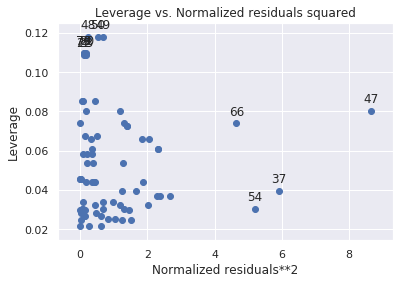

In [46]:
sm.graphics.plot_leverage_resid2(model_burglary, alpha=0.05);
plt.show()

## Attempt 2d:

This model results in a slightly better fit, but two of our P-Values (Minority_PCT and the interaction) are still not low enough - confidence intervals still on the edge of acceptable. 

In [80]:
census_df_filtered = census_df_filtered.drop([47,54,66,37])
model_burglary = smf.ols(formula='burglary_rate ~ COLLEGE_RATE*PCT_MINORITY', data=census_df_filtered).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     22.61
Date:                Sun, 03 May 2020   Prob (F-statistic):           3.18e-10
Time:                        22:57:00   Log-Likelihood:                 344.87
No. Observations:                  71   AIC:                            -681.7
Df Residuals:                      67   BIC:                            -672.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0029      0.002     -1.363      0.178      -0.007       0.001
COLLEGE_RATE                  0.0156      0.003      4.496      0.000       0.009       0.022
PCT_MINORITY               5.454e-05   2.77e-05      1.972      0.053   -6.75e-07       0.000
COLLEGE_RATE:PCT_MINORITY     0.0002      7e-05      2.435      0.018    3.08e-05       0.000
==============================================================================
Omnibus:                        7.998   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                2.865
Skew:                          -0.058   Prob(JB):                        0.239
Kurtosis:                       2.023   Cond. No.                         734.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Check again for Outliers

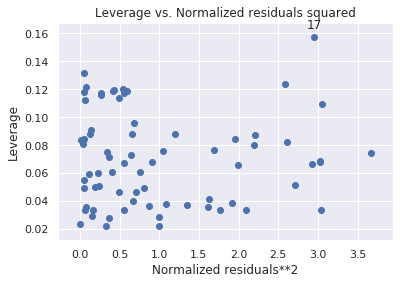

In [72]:
sm.graphics.plot_leverage_resid2(model_burglary, alpha=0.05);
plt.show()

## Attempt 2e:

For the next model results, we remove the interaction since it’s P-value did not improve with outlier removal. The result is a much better fit, and lower acceptable P-Values for Minority_PCT, and College_Rate - though the confidence interval for Minority_PCT still includes zero. So far we’ve only removed less than 1/5th of data points  (compared to 1/3rd in the first attempt).

In [84]:
census_df_filtered = census_df_filtered.drop([17,16,53,53,0,52,61,1,55])
model_burglary = smf.ols(formula='burglary_rate ~ COLLEGE_RATE+PCT_MINORITY', data=census_df_filtered).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     50.73
Date:                Sun, 03 May 2020   Prob (F-statistic):           1.27e-13
Time:                        23:14:43   Log-Likelihood:                 313.19
No. Observations:                  63   AIC:                            -620.4
Df Residuals:                      60   BIC:                            -613.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0051      0.002     -2.478      0.016      -0.009      -0.001
COLLEGE_RATE     0.0221      0.003      6.858      0.000       0.016       0.029
PCT_MINORITY  9.434e-05   2.55e-05      3.696      0.000    4.33e-05       0.000
==============================================================================
Omnibus:                        3.109   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                1.863
Skew:                           0.164   Prob(JB):                        0.394
Kurtosis:                       2.224   Cond. No.                         756.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

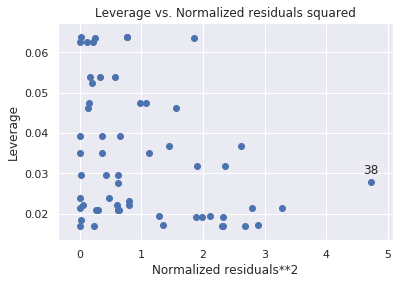

In [92]:
sm.graphics.plot_leverage_resid2(model_burglary, alpha=0.05);
plt.show()

## Attempt 2f (Final):

For the final model, we remove 3 more outliers to achieve an R-squared of .6 (right around where we ended the first study). We remove Minority Percentage since the confidence interval was not improving. 

In [93]:
census_df_filtered = census_df_filtered.drop([14,36,38])
model_burglary = smf.ols(formula='burglary_rate ~ COLLEGE_RATE', data=census_df_filtered).fit()
model_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          burglary_rate   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     89.82
Date:                Sun, 03 May 2020   Prob (F-statistic):           3.08e-13
Time:                        23:18:19   Log-Likelihood:                 287.44
No. Observations:                  58   AIC:                            -570.9
Df Residuals:                      56   BIC:                            -566.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0020      0.001      3.890      0.000       0.001       0.003
COLLEGE_RATE     0.0114      0.001      9.478      0.000       0.009       0.014
==============================================================================
Omnibus:                        8.240   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                2.705
Skew:                          -0.039   Prob(JB):                        0.259
Kurtosis:                       1.945   Cond. No.                         6.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Overall Conclusion:

Our attempts to improve the burglary model were somewhat successful, we were able to achieve an R-squared of .6 by only removing out 1/5th of the samples compared to 1/3rd from the first analysis. Though there was an improvement, the second model is far from perfect and likely wouldn’t be great for predictive purposes because the R-squared is still fairly low and there are some glaring flaws. The sample size is still relatively small despite attempts to increase it - while we added some additional rows and crime rates,the statistic we use for the final model (College Education Rate) did not increase in sample size. 

Overall, while we were able to observe correlations between crime rates and census & home sales statistics, the correlations weren’t quite strong enough to fit an accurate predictive regression model. The best way to improve further would be to find more data - perhaps census statistics broken out by year. 